<a href="https://colab.research.google.com/github/nihalhabeeb/Retail-Sales-Prediction/blob/main/Retail_Sales_Prediction_Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><u> Predicting Sales of a Major Retail Store Using Regression Machine Learning Models</u></b>

## <b> Problem Description </b>

### Rossmann operates over 3,000 drug stores in 7 European countries. Currently, Rossmann store managers are tasked with predicting their daily sales for up to six weeks in advance. Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality. With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied.

### You are provided with historical sales data for 1,115 Rossmann stores. The task is to forecast the "Sales" column for the test set. Note that some stores in the dataset were temporarily closed for refurbishment.

## <b> Data Description </b>

### <b>Rossmann Stores Data.csv </b> - historical data including Sales
### <b>store.csv </b> - supplemental information about the stores


### <b><u>Data fields</u></b>
### Most of the fields are self-explanatory. The following are descriptions for those that aren't.

* #### Id - an Id that represents a (Store, Date) duple within the test set
* #### Store - a unique Id for each store
* #### Sales - the turnover for any given day (this is what you are predicting)
* #### Customers - the number of customers on a given day
* #### Open - an indicator for whether the store was open: 0 = closed, 1 = open
* #### StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
* #### SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools
* #### StoreType - differentiates between 4 different store models: a, b, c, d
* #### Assortment - describes an assortment level: a = basic, b = extra, c = extended
* #### CompetitionDistance - distance in meters to the nearest competitor store
* #### CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened
* #### Promo - indicates whether a store is running a promo on that day
* #### Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
* #### Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2
* #### PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

Predicting the sales in advance is a necessary task for any type of retail stores. A store might have to estimate the sales at a particular time maybe months in advance so that they can prepare for the expenses (in order to satisfy the customer demand) and further estimate their revenue. An inaccurate prediction could result in losses or failure to make the profit that they could have potentially made.

We will use regression based machine learning models to forecast the daily sales of Rossmann stores. Regression is a set of mathematical methods that can be used to estimate the relationship between a continuous variable and single or multiple independent variables, allowing us to predict the value of the variable based on the values of the independent variables.

We will apply linear regression, decision tree regression and random forest regression models to predict sales. We will compare the performances of all the models and see which one gives the best results.

In [126]:
#importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

In [127]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [128]:
# Rossmann stores dataset
df = pd.read_csv('/content/drive/MyDrive/AlmaBetter/Retail Sales Prediction - Nihal Habeeb/Rossmann Stores Data.csv')
# store dataset
store_df = pd.read_csv('/content/drive/MyDrive/AlmaBetter/Retail Sales Prediction - Nihal Habeeb/store.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [129]:
# dataset with information by date for different stores
df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [130]:
# dataset with information unique to each stores
store_df.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


## Data cleaning

First let us start by handling the missing values in the store_df columns. **Note:** None of the rows can be removed as they contain unique information about each of the stores.

### Handling missing values : store_df

In [131]:
# checking if there are any duplicates of store information
store_df.Store.duplicated().sum()

0

In [132]:
store_df.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

Before imputing a value to the null values of CompetitionDistance we need to understand if there is any role for CompetitionDistance in CompetitionOpenSinceMonth and CompetitionOpenSinceYear having null values.

In [133]:
# the data where CompetitionOpenSinceMonth is null
store_df[store_df['CompetitionOpenSinceMonth'].isna()].shape

(354, 10)

In [134]:
store_df.loc[(store_df['CompetitionOpenSinceMonth'].isna()) & (store_df['CompetitionOpenSinceYear'].isna())]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
11,12,a,c,1070.0,NaN,NaN,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
12,13,d,a,310.0,NaN,NaN,1,45.0,2009.0,"Feb,May,Aug,Nov"
15,16,a,c,3270.0,NaN,NaN,0,NaN,NaN,NaN
18,19,a,c,3240.0,NaN,NaN,1,22.0,2011.0,"Mar,Jun,Sept,Dec"
21,22,a,a,1040.0,NaN,NaN,1,22.0,2012.0,"Jan,Apr,Jul,Oct"
...,...,...,...,...,...,...,...,...,...,...
1095,1096,a,c,1130.0,NaN,NaN,1,10.0,2014.0,"Mar,Jun,Sept,Dec"
1099,1100,a,a,540.0,NaN,NaN,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1113,1114,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN


We can see that CompetitionOpenSinceMonth and CompetitionOpenSinceYear have null values together always which makes sense as they both have information related to time of the competition.

Comparing the data where they are null and where they are not null, it seems like there is no relation between CompetitionDistance and these columns being null. Since there are large number of null values in these columns and they cannot be replaced meaningfully, they are dropped completely.

Looking at the null values related to Promo (Promo2SinceWeek, Promo2SinceYear, PromoInterval)

In [135]:
# data where Promo2SinceWeek, Promo2SinceYear and PromoInterval are null
store_df.loc[(store_df['Promo2SinceWeek'].isna()) & (store_df['Promo2SinceYear'].isna()) & (store_df['PromoInterval'].isna())].shape

(544, 10)

In [136]:
# data where Promo2SinceWeek, Promo2SinceYear and PromoInterval are null and Promo2 is 0
store_df.loc[(store_df['Promo2SinceWeek'].isna()) & (store_df['Promo2SinceYear'].isna()) & (store_df['PromoInterval'].isna()) & (store_df['Promo2'] == 0)].shape

(544, 10)

We know there are 571 non null values (hence 544 null values) for each columns, and from the dataset shapes above we can see that these 3 columns have null values only when Promo2 is zero i.e there is no promotion. This makes sense as these columns don't have any information to provide if the store doesn't have Promo2.

For now, we can remove these columns as the null values cannot be replaced meaningfully.

In [137]:
# dropping columns with missing values
store_df.drop(columns=['CompetitionOpenSinceMonth','CompetitionOpenSinceYear','Promo2SinceWeek','Promo2SinceYear','PromoInterval'], axis=1, inplace = True)

In [138]:
# imputing mean CompetitionDistance values for the three null values
store_df.loc[store_df['CompetitionDistance'].isna(),'CompetitionDistance'] = round(store_df['CompetitionDistance'].mean(),1)

In [139]:
store_df.isnull().sum()

Store                  0
StoreType              0
Assortment             0
CompetitionDistance    0
Promo2                 0
dtype: int64

### Handling missing values: df table

In [140]:
df.isnull().sum()

Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

There are no null values in this dataframe.

## Joining Dataframes

In [141]:
## joining the two tables
joined_df = pd.merge(df, store_df, how = 'left')

In [142]:
joined_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,Promo2
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,0
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,1
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,0
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,0


In [143]:
joined_df.isnull().sum()

Store                  0
DayOfWeek              0
Date                   0
Sales                  0
Customers              0
Open                   0
Promo                  0
StateHoliday           0
SchoolHoliday          0
StoreType              0
Assortment             0
CompetitionDistance    0
Promo2                 0
dtype: int64

All the missing values were handled earlier before joining the tables.

## Exploratory Data Analysis

In [144]:
# descriptive statistics
joined_df.describe(include = 'all')

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,Promo2
count,1.017209e+06,1.017209e+06,1017209,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1017209,1.017209e+06,1017209,1017209,1.017209e+06,1.017209e+06
unique,NaN,NaN,942,NaN,NaN,NaN,NaN,5,NaN,4,3,NaN,NaN
top,NaN,NaN,2015-07-31,NaN,NaN,NaN,NaN,0,NaN,a,a,NaN,NaN
freq,NaN,NaN,1115,NaN,NaN,NaN,NaN,855087,NaN,551627,537445,NaN,NaN
mean,5.584297e+02,3.998341e+00,NaN,5.773819e+03,6.331459e+02,8.301067e-01,3.815145e-01,NaN,1.786467e-01,NaN,NaN,5.430020e+03,5.005638e-01
std,3.219087e+02,1.997391e+00,NaN,3.849926e+03,4.644117e+02,3.755392e-01,4.857586e-01,NaN,3.830564e-01,NaN,NaN,7.705298e+03,4.999999e-01
min,1.000000e+00,1.000000e+00,NaN,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,0.000000e+00,NaN,NaN,2.000000e+01,0.000000e+00
25%,2.800000e+02,2.000000e+00,NaN,3.727000e+03,4.050000e+02,1.000000e+00,0.000000e+00,NaN,0.000000e+00,NaN,NaN,7.100000e+02,0.000000e+00
50%,5.580000e+02,4.000000e+00,NaN,5.744000e+03,6.090000e+02,1.000000e+00,0.000000e+00,NaN,0.000000e+00,NaN,NaN,2.330000e+03,1.000000e+00
75%,8.380000e+02,6.000000e+00,NaN,7.856000e+03,8.370000e+02,1.000000e+00,1.000000e+00,NaN,0.000000e+00,NaN,NaN,6.880000e+03,1.000000e+00


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


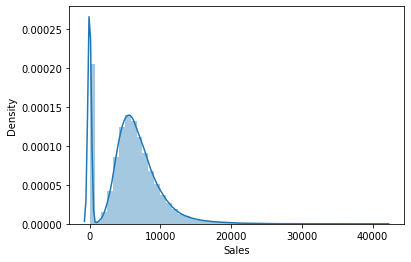

In [145]:
# distribution plot
sns.distplot(joined_df['Sales'])

The distribution is close to normal, but we can see a huge spike close to zero. This is because the data contains a lot of entries where the store was closed. Obviously, the total sales will be zero for such data. We can ignore the data where store is closed as it doesn't help in predicting the sales.

In [146]:
# only keeping the data where store is open
openstores_df = joined_df[joined_df['Open'] != 0]

In [147]:
openstores_df.shape

(844392, 13)

In [148]:
joined_df.shape

(1017209, 13)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


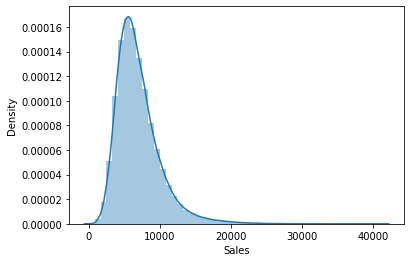

In [149]:
# distribution of sales
sns.distplot(openstores_df['Sales'])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


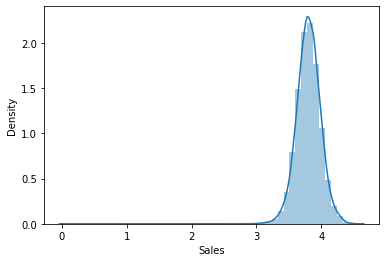

In [150]:
# distribution of log transformation of sales
sns.distplot(np.log10(openstores_df['Sales']+1))

While taking log transformation of Sales, the data containing 0 Sales will be a problem as log(0) is infinity. So they are replaced with a close non zero value. We will also have to do the same for customers, as sales with 0 value could be linked with customers column with 0 values as well.

In [151]:
# making copy of the dataset
dataset = openstores_df.copy()

In [152]:
# replacing 0 sales values with 0.5
dataset.loc[dataset['Sales'] == 0,'Sales'] = 0.5
dataset.loc[dataset['Customers'] == 0,'Customers'] = 0.5

In [153]:
# drop Open column as we only included data with Open = 1 making the column redundant
dataset.drop('Open', axis = 1, inplace = True)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


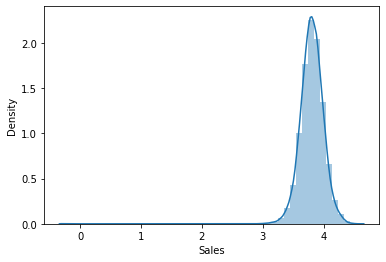

In [154]:
# log transformation of sales
sns.distplot(np.log10(dataset['Sales']))

### Relationship with numerical variables

In [155]:
# list of all the numerical features
numerical_features = list(dataset.describe().columns)
# remove Store (which is just an ID of each stores)
numerical_features.remove('Store')
# remove dependent variable (Sales)
numerical_features.remove('Sales')
numerical_features

['DayOfWeek',
 'Customers',
 'Promo',
 'SchoolHoliday',
 'CompetitionDistance',
 'Promo2']

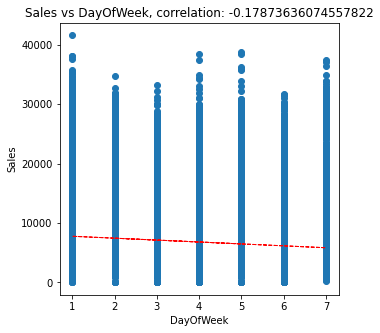

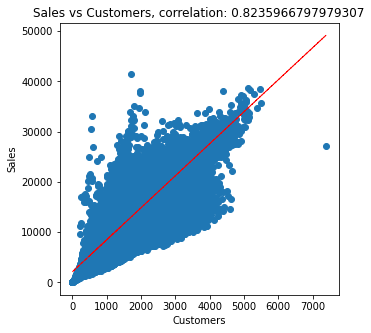

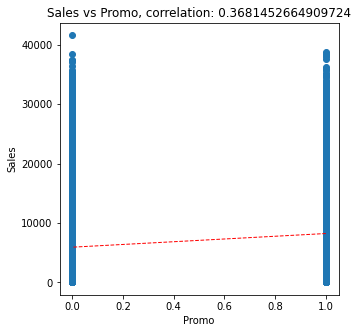

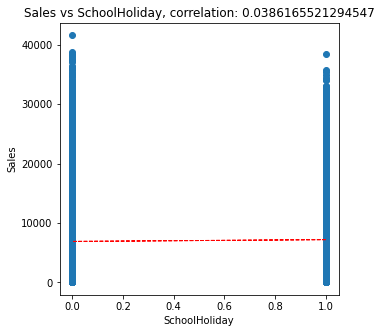

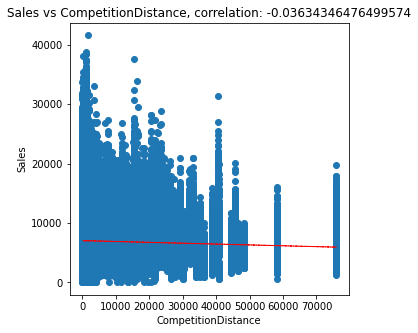

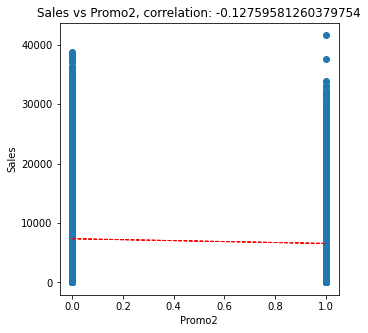

In [156]:
# plotting the relationship between each numerical features and the Sales variable
for col in numerical_features:
  fig = plt.figure(figsize = (5,5))
  feature = dataset[col]
  label = dataset['Sales']
  # correlation coefficient
  correlation = feature.corr(label)
  # plot
  plt.scatter(feature,label)
  plt.xlabel(col)
  plt.ylabel('Sales')
  plt.title('Sales vs '+col+', correlation: '+ str(correlation))
  # getting best fit line for each relationship
  slope, intercept = np.polyfit(feature, label, 1)
  plt.plot(feature, slope*feature + intercept, "r--", lw = 1)
plt.show()

There is a good linear relationship between Sales and Customers but there is heteroscedasticity. We can try log transformation of Sales variable.

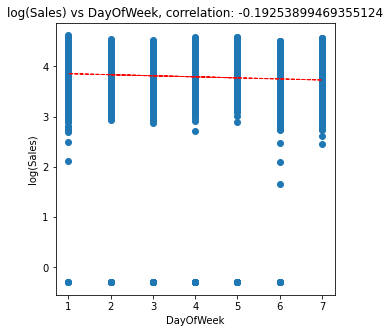

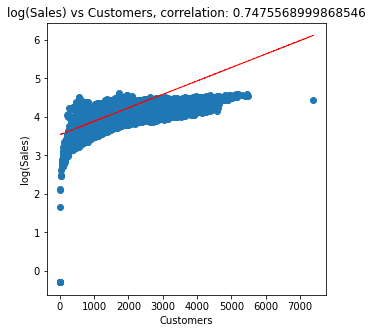

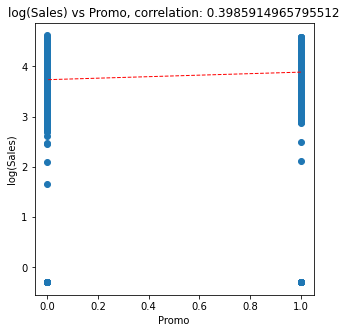

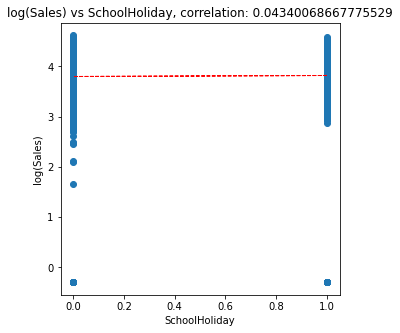

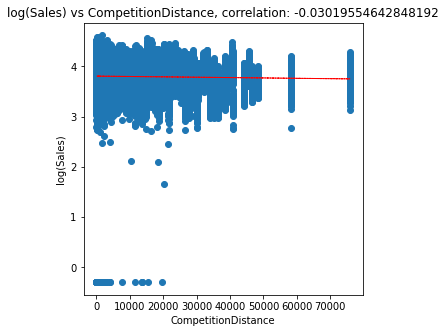

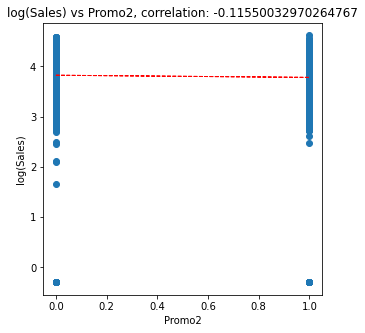

In [157]:
# plotting the relationship between features and log transformation of Sales variable
for col in numerical_features:
  fig = plt.figure(figsize = (5,5))
  feature = dataset[col]
  label = np.log10(dataset['Sales'])
  # correlation coefficient
  correlation = feature.corr(label)
  # plot
  plt.scatter(feature,label)
  plt.xlabel(col)
  plt.ylabel('log(Sales)')
  plt.title('log(Sales) vs '+col+', correlation: '+ str(correlation))
  # getting best fit line for each relationship
  slope, intercept = np.polyfit(feature, label, 1)
  plt.plot(feature, slope*feature + intercept, "r--", lw = 1)
plt.show()

The relationship between Customers and log tansformation of Sales variable is not linear. Let us look at the relationship between log transformation of both variables.

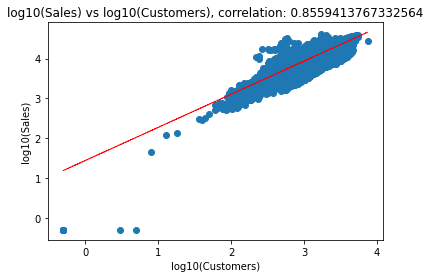

In [158]:
feature = np.log10(dataset['Customers'])
label = np.log10(dataset['Sales'])
# correlation coefficient
correlation = feature.corr(label)
plt.scatter(feature, label)
plt.xlabel('log10(Customers)')
plt.ylabel('log10(Sales)')
plt.title('log10(Sales) vs log10(Customers), correlation: '+ str(correlation))
# getting best fit line for each relationship
slope, intercept = np.polyfit(feature, label, 1)
plt.plot(feature, slope*feature + intercept, "r--", lw = 1)

We will create a log10(Customers) column

In [159]:
# log transformation of customers
dataset['Log_Customers'] = np.log10(dataset['Customers'])

In [160]:
dataset.head()

,Store,DayOfWeek,Date,Sales,Customers,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,Promo2,Log_Customers
0,1,5,2015-07-31,5263.0,555.0,1,0,1,c,a,1270.0,0,2.744293
1,2,5,2015-07-31,6064.0,625.0,1,0,1,a,a,570.0,1,2.795880
2,3,5,2015-07-31,8314.0,821.0,1,0,1,a,a,14130.0,1,2.914343
3,4,5,2015-07-31,13995.0,1498.0,1,0,1,c,c,620.0,0,3.175512
4,5,5,2015-07-31,4822.0,559.0,1,0,1,a,a,29910.0,0,2.747412


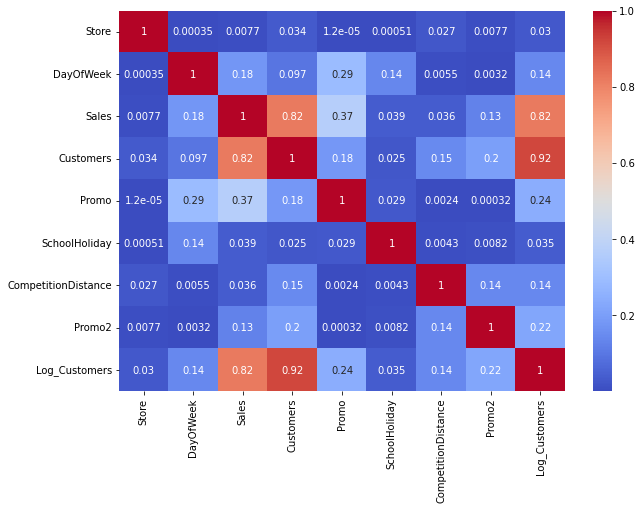

In [161]:
# correlation heat map
plt.figure(figsize = (10,7))
correlation = dataset.corr()
sns.heatmap(abs(correlation), annot = True, cmap = 'coolwarm')

We do not find any multicollinearity between the dependent variables except for Customers and Log(Customers) for obvious reasons. Only the log transformation will be used in the model. We can see good correlation between customers variable and sales variable.

Variance Inflation Factor (VIF)

In [162]:
# Checking for multicollinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor
def calculate_vif(X):

    # VIF calculation
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

In [163]:
calculate_vif(dataset[numerical_features])

,variables,VIF
0,DayOfWeek,3.229168
1,Customers,3.358126
2,Promo,1.853215
3,SchoolHoliday,1.214039
4,CompetitionDistance,1.411571
5,Promo2,1.779197


Since all the variables have low VIF and did not show high correlation between them we decide to not drop any of them (**Note**: we will only be using log transformation of customers instead of customers column.

### Relationship with Non numerical variables

In [164]:
dataset.describe(include = 'object')

,Date,StateHoliday,StoreType,Assortment
count,844392,844392,844392,844392
unique,942,5,4,3
top,2014-04-16,0,a,a
freq,1115,731342,457077,444909


In [165]:
from datetime import datetime

# converting the string date values to datetime format
dataset['Date'] = dataset['Date'].apply(lambda x: datetime.strptime(x,'%Y-%m-%d'))

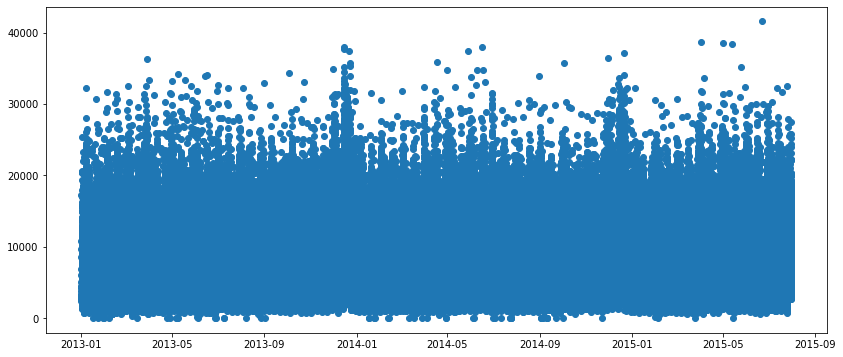

In [166]:
# relation between date and sales
plt.figure(figsize = (14,6))
plt.scatter(dataset['Date'],dataset['Sales'])

In [167]:
# creating year column
dataset['Year'] = dataset['Date'].apply(lambda x: x.year)
# creating month column
dataset['Month'] = dataset['Date'].apply(lambda x: x.month)

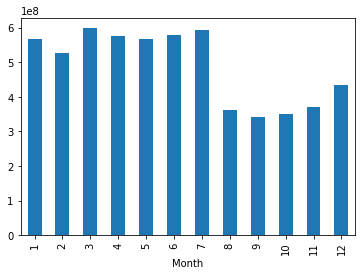

In [168]:
# total sales in each month
dataset.groupby('Month')['Sales'].sum().plot(kind = 'bar')

We can see that sales from August to December is low compared to the rest of the year. The highest sales is in March.

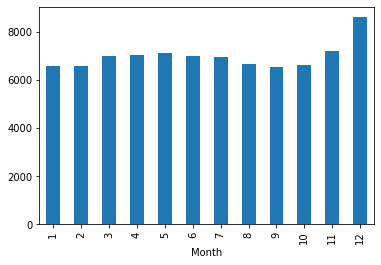

In [169]:
# average sales in each month
dataset.groupby('Month')['Sales'].mean().plot(kind = 'bar')

Eventhough total sales is low, average sales is highest in December.

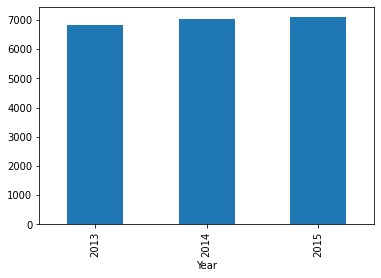

In [170]:
# average sales in each year
dataset.groupby('Year')['Sales'].mean().plot(kind = 'bar')

One of the columns retrieved from the date data, either year or month, can be used in the model. We cannot use both the columns as they will be highly correlated.

Looking at the State Holiday column.

In [171]:
# distribution of StateHoliday column across the categories
dataset['StateHoliday'].value_counts()

0    731342
0    112140
a       694
b       145
c        71
Name: StateHoliday, dtype: int64

In [172]:
# shape of dataset where values are 0 (integer)
dataset[dataset['StateHoliday'] == 0].shape

(112140, 15)

In [173]:
# shape of dataset where values are 0 (string)
dataset[dataset['StateHoliday'] == '0'].shape

(731342, 15)

We can spot something unusual here. There are two 'zero' categories. One of them is integer while the other one is string ('0'). Since the rest of the categories are strings we can convert the integer 0 to string.

In [174]:
# replacing the integer 0 to '0'
dataset.loc[dataset['StateHoliday'] == 0, 'StateHoliday'] = '0'

In [175]:
# checking value counts again
dataset['StateHoliday'].value_counts()

0    843482
a       694
b       145
c        71
Name: StateHoliday, dtype: int64

Text(0.5, 1.0, 'Sales vs StateHoliday')

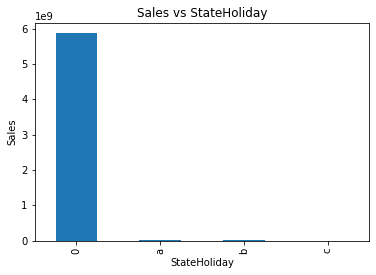

In [176]:
# total sales by StateHoliday
dataset.groupby('StateHoliday')['Sales'].sum().plot(kind = 'bar')
plt.ylabel('Sales')
plt.title('Sales vs StateHoliday')

Most of the sales happened are not on holidays.

In [177]:
dataset.groupby('StateHoliday')['Sales'].sum()

StateHoliday
0    5.865165e+09
a    5.890305e+06
b    1.433744e+06
c    6.918060e+05
Name: Sales, dtype: float64

Looking at School Holiday variable (which states whether the store is affected by school closure or not).

Text(0.5, 1.0, 'Sales vs SchoolHoliday')

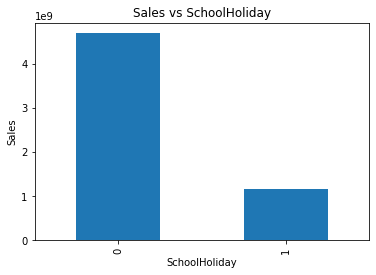

In [178]:
# total sales by SchoolHoliday
dataset.groupby('SchoolHoliday')['Sales'].sum().plot(kind = 'bar')
plt.ylabel('Sales')
plt.title('Sales vs SchoolHoliday')

Most of the sales are unaffected by the closure of public schools.

Looking at StoreType data.

In [179]:
# distribution of StoreType data
dataset['StoreType'].value_counts()

a    457077
d    258774
c    112978
b     15563
Name: StoreType, dtype: int64

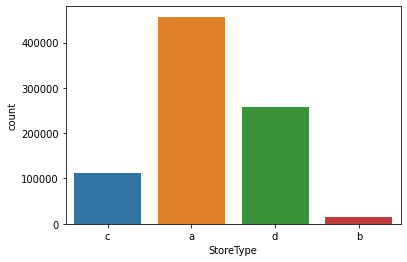

In [180]:
# countplot of StoreType data
sns.countplot(x = 'StoreType', data = dataset)

Text(0.5, 1.0, 'Sales vs StoreType')

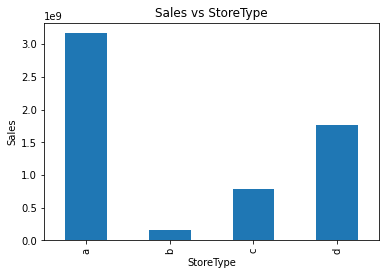

In [181]:
# total sales by StoreType
dataset.groupby('StoreType')['Sales'].sum().plot(kind = 'bar')
plt.ylabel('Sales')
plt.title('Sales vs StoreType')

Storetype a followed by type d has the most sales.

Looking at Assortment data.

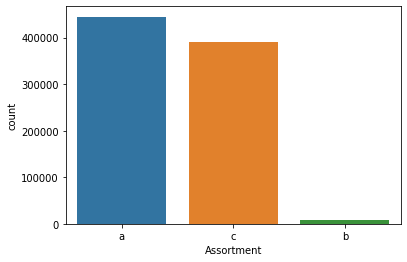

In [182]:
# distribution of Assortment data
sns.countplot(x = 'Assortment', data = dataset)

Text(0.5, 1.0, 'Sales vs Assortment')

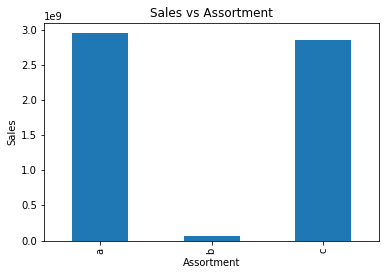

In [183]:
# total sales by Assortment
dataset.groupby('Assortment')['Sales'].sum().plot(kind = 'bar')
plt.ylabel('Sales')
plt.title('Sales vs Assortment')

Assortment a and c has fairly high sales compared to type b.

Looking at sales across days of the week.

Text(0.5, 1.0, 'Sales vs Day of Week')

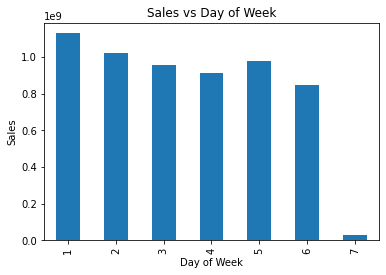

In [184]:
# total sales in by Days of the week
dataset.groupby('DayOfWeek')['Sales'].sum().plot(kind = 'bar')
plt.ylabel('Sales')
plt.xlabel('Day of Week')
plt.title('Sales vs Day of Week')

First day (monday) has the highest sales and seventh day (Sunday) has the lowest sales. We already know that sales is low on holidays.

### Encoding

All the binary variables were already in numerical form (0 and 1) so we did not have to do any conversion. The features with multiple categories can be converted to numerical form using one hot encoding method. We remove one of the dummy variables of each column (using drop_first parameter) as the same information can be retrieved from the rest of the variables.

In [185]:
# one hot encoding
dataset = pd.get_dummies(dataset, columns = ['StateHoliday','StoreType','Assortment'], prefix = ['StateHoliday','StoreType','Asstmnt'], drop_first = True)

In [186]:
dataset.head()

,Store,DayOfWeek,Date,Sales,Customers,Promo,SchoolHoliday,CompetitionDistance,Promo2,Log_Customers,Year,Month,StateHoliday_a,StateHoliday_b,StateHoliday_c,StoreType_b,StoreType_c,StoreType_d,Asstmnt_b,Asstmnt_c
0,1,5,2015-07-31,5263.0,555.0,1,1,1270.0,0,2.744293,2015,7,0,0,0,0,1,0,0,0
1,2,5,2015-07-31,6064.0,625.0,1,1,570.0,1,2.795880,2015,7,0,0,0,0,0,0,0,0
2,3,5,2015-07-31,8314.0,821.0,1,1,14130.0,1,2.914343,2015,7,0,0,0,0,0,0,0,0
3,4,5,2015-07-31,13995.0,1498.0,1,1,620.0,0,3.175512,2015,7,0,0,0,0,1,0,0,1
4,5,5,2015-07-31,4822.0,559.0,1,1,29910.0,0,2.747412,2015,7,0,0,0,0,0,0,0,0


## Fitting the model

In [187]:
# list of variables
features = numerical_features + ['Month','Log_Customers','Date','StateHoliday_a','StateHoliday_b','StateHoliday_c','StoreType_b','StoreType_c','StoreType_d','Asstmnt_b','Asstmnt_c']

In [188]:
features

['DayOfWeek',
 'Customers',
 'Promo',
 'SchoolHoliday',
 'CompetitionDistance',
 'Promo2',
 'Month',
 'Log_Customers',
 'Date',
 'StateHoliday_a',
 'StateHoliday_b',
 'StateHoliday_c',
 'StoreType_b',
 'StoreType_c',
 'StoreType_d',
 'Asstmnt_b',
 'Asstmnt_c']

In [189]:
# removing date column as the effect on sales is unclear
features.remove('Date')
# removing customers column (using log transformation of customers in the model)
features.remove('Customers')

features

['DayOfWeek',
 'Promo',
 'SchoolHoliday',
 'CompetitionDistance',
 'Promo2',
 'Month',
 'Log_Customers',
 'StateHoliday_a',
 'StateHoliday_b',
 'StateHoliday_c',
 'StoreType_b',
 'StoreType_c',
 'StoreType_d',
 'Asstmnt_b',
 'Asstmnt_c']

In [190]:
dataset[features].head()

,DayOfWeek,Promo,SchoolHoliday,CompetitionDistance,Promo2,Month,Log_Customers,StateHoliday_a,StateHoliday_b,StateHoliday_c,StoreType_b,StoreType_c,StoreType_d,Asstmnt_b,Asstmnt_c
0,5,1,1,1270.0,0,7,2.744293,0,0,0,0,1,0,0,0
1,5,1,1,570.0,1,7,2.795880,0,0,0,0,0,0,0,0
2,5,1,1,14130.0,1,7,2.914343,0,0,0,0,0,0,0,0
3,5,1,1,620.0,0,7,3.175512,0,0,0,0,1,0,0,1
4,5,1,1,29910.0,0,7,2.747412,0,0,0,0,0,0,0,0


In [191]:
# splitting the dataset into:
# dataset of independent variables
X = dataset[features]
# dependent variable dataset
y = np.log10(dataset['Sales'])

In [192]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [193]:
# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [194]:
# standardizing the data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Linear Regression

In [195]:
# Fitting Multiple Linear Regression Model to the training dataset
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [196]:
# the model intercept
model.intercept_

0.8456847335989046

In [197]:
# model coefficients
model.coef_

array([-3.70660499e-03,  6.25922783e-02,  1.68622926e-03,  1.27507312e-01,
        2.82872317e-02,  1.14027980e-02,  3.69863118e+00, -9.97336553e-03,
       -2.08832274e-03,  9.00917097e-02, -9.19544131e-02, -9.21483255e-03,
        8.81828111e-02, -1.79525058e-01,  1.62870064e-02])

In [198]:
# predicted sales from training dataset
y_train_pred = model.predict(X_train)
# predicted sales from testing dataset
y_pred = model.predict(X_test)

In [199]:
# mean squared error of model on training dataset
# comparison between actual sales and predicted sales
ms_train = mean_squared_error(10**(y_train), 10**(y_train_pred))
# mean squared error of model on testing dataset
# comparison between actual sales and predicted sales
ms_test = mean_squared_error(10**(y_test), 10**(y_pred))

# root mean squared error of model on training dataset
rms_train = math.sqrt(ms_train)
# root mean squared error of model on testing dataset
rms_test = math.sqrt(ms_test)

# r2 score of model on training data
r2_score_train = r2_score(10**(y_train), 10**(y_train_pred))
# r2 score of model on testing data
r2_score_test = r2_score(10**(y_test), 10**(y_pred))

In [200]:
# Total sample size
N = dataset.shape[0]
# Number of independent variables
p = dataset[features].shape[1]

# adjusted r2 score of training data
adjusted_r2_train = 1 - ((1 - r2_score_train)*(N - 1))/(N - p - 1)
adjusted_r2_test = 1 - ((1 - r2_score_test)*(N - 1))/(N - p - 1)

In [201]:
print('Model Performance on Training Data')
print('Mean Squared Error:',ms_train)
print('Root Mean Squared Error:',rms_train)
print('R2 Score:', r2_score_train)
print('Adjusted R2 Score:', adjusted_r2_train)
print('\nModel Performance on Testing Data')
print('Mean Squared Error:',ms_test)
print('Root Mean Squared Error:',rms_test)
print('R2 Score:', r2_score_test)
print('Adjusted R2 Score:', adjusted_r2_test)

Model Performance on Training Data
Mean Squared Error: 1473534.0848456738
Root Mean Squared Error: 1213.8921224086075
R2 Score: 0.8473105550352016
Adjusted R2 Score: 0.8473078425686292

Model Performance on Testing Data
Mean Squared Error: 1470545.1018776507
Root Mean Squared Error: 1212.6603406880472
R2 Score: 0.846474778432183
Adjusted R2 Score: 0.8464720511183755


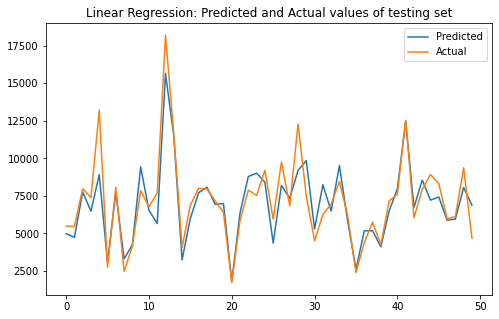

In [202]:
plt.figure(figsize=(8,5))
plt.plot(10**(y_pred[0:50]))
plt.plot(np.array(10**(y_test[0:50])))
plt.legend(["Predicted","Actual"])
plt.title("Linear Regression: Predicted and Actual values of testing set")
plt.show()

## Lasso Regularization

In [203]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

In [204]:
# hyperparameter tuning and cross validation
lasso = Lasso()
parameters = {'alpha':[1e-15,1e-13,1e-10,1e-8,1e-5,1e-4,1e-3,1e-2,1e-1]}
lasso_regression = GridSearchCV(lasso, parameters, scoring = 'neg_mean_squared_error', cv = 3)
# model fitting
lasso_regression.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=Lasso(),
             param_grid={'alpha': [1e-15, 1e-13, 1e-10, 1e-08, 1e-05, 0.0001,
                                   0.001, 0.01, 0.1]},
             scoring='neg_mean_squared_error')

In [205]:
# the best alpha parameter
lasso_regression.best_params_

{'alpha': 1e-08}

In [206]:
# negative mean squared error for the model with the best parameter 
lasso_regression.best_score_

-0.005009770629946813

In [207]:
# model prediction
y_pred_lasso = lasso_regression.predict(X_test)
y_train_pred_lasso = lasso_regression.predict(X_train)

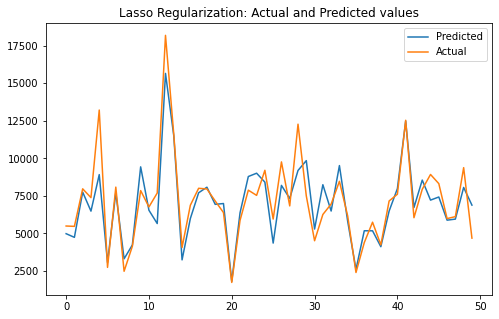

In [208]:
# comparing predicted and actual values
plt.figure(figsize=(8,5))
plt.plot(10**(y_pred_lasso[0:50]))
plt.plot(np.array(10**(y_test[0:50])))
plt.legend(["Predicted","Actual"])
plt.title("Lasso Regularization: Actual and Predicted values")
plt.show()

In [209]:
# mean squared error of model on training dataset
# comparison between actual sales and predicted sales
ms_train_lasso = mean_squared_error(10**(y_train), 10**(y_train_pred_lasso))
# mean squared error of model on testing dataset
# comparison between actual sales and predicted sales
ms_test_lasso = mean_squared_error(10**(y_test), 10**(y_pred_lasso))

# root mean squared error of model on training dataset
rms_train_lasso = math.sqrt(ms_train_lasso)
# root mean squared error of model on testing dataset
rms_test_lasso = math.sqrt(ms_test_lasso)

# r2 score of model on training data
r2_score_train_lasso = r2_score(10**(y_train), 10**(y_train_pred_lasso))
# r2 score of model on testing data
r2_score_test_lasso = r2_score(10**(y_test), 10**(y_pred_lasso))

In [210]:
# adjusted r2 score of training data
adjusted_r2_train_lasso = 1 - ((1 - r2_score_train_lasso)*(N - 1))/(N - p - 1)
adjusted_r2_test_lasso = 1 - ((1 - r2_score_test_lasso)*(N - 1))/(N - p - 1)

In [211]:
print('Model Performance on Training Data')
print('Mean Squared Error:',ms_train_lasso)
print('Root Mean Squared Error:',rms_train_lasso)
print('R2 Score:', r2_score_train_lasso)
print('Adjusted R2 Score:', adjusted_r2_train_lasso)
print('\nModel Performance on Testing Data')
print('Mean Squared Error:',ms_test_lasso)
print('Root Mean Squared Error:',rms_test_lasso)
print('R2 Score:', r2_score_test_lasso)
print('Adjusted R2 Score:', adjusted_r2_test_lasso)

Model Performance on Training Data
Mean Squared Error: 1473532.9983252706
Root Mean Squared Error: 1213.891674872709
R2 Score: 0.8473106676218048
Adjusted R2 Score: 0.8473079551572326

Model Performance on Testing Data
Mean Squared Error: 1470543.217938401
Root Mean Squared Error: 1212.6595639083548
R2 Score: 0.8464749751158416
Adjusted R2 Score: 0.8464722478055281


## Ridge Regularization

In [212]:
from sklearn.linear_model import Ridge

In [213]:
# hyperparameter tuning and cross validation
ridge = Ridge()
parameters = {'alpha': [1e-10,1e-8,1e-5,1e-4,1e-3,1e-2,1,5,10,20,30,40,45]}
ridge_regression = GridSearchCV(ridge, parameters, scoring = 'neg_mean_squared_error', cv = 3)
ridge_regression.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=Ridge(),
             param_grid={'alpha': [1e-10, 1e-08, 1e-05, 0.0001, 0.001, 0.01, 1,
                                   5, 10, 20, 30, 40, 45]},
             scoring='neg_mean_squared_error')

In [214]:
ridge_regression.best_params_

{'alpha': 0.01}

In [215]:
ridge_regression.best_score_

-0.00500977087360837

In [216]:
# model predictions
y_pred_ridge = ridge_regression.predict(X_test)
y_train_pred_ridge = ridge_regression.predict(X_train)

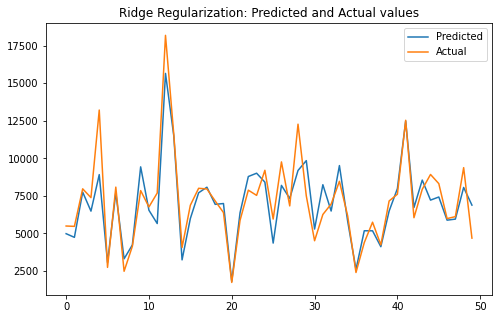

In [217]:
# plotting predicted and actual values
plt.figure(figsize=(8,5))
plt.plot(10**(y_pred_ridge[0:50]))
plt.plot(np.array(10**(y_test[0:50])))
plt.legend(["Predicted","Actual"])
plt.title("Ridge Regularization: Predicted and Actual values")
plt.show()

In [218]:
# mean squared error of model on training dataset
# comparison between actual sales and predicted sales
ms_train_ridge = mean_squared_error(10**(y_train), 10**(y_train_pred_ridge))
# mean squared error of model on testing dataset
# comparison between actual sales and predicted sales
ms_test_ridge = mean_squared_error(10**(y_test), 10**(y_pred_ridge))

# root mean squared error of model on training dataset
rms_train_ridge = math.sqrt(ms_train_ridge)
# root mean squared error of model on testing dataset
rms_test_ridge = math.sqrt(ms_test_ridge)

# r2 score of model on training data
r2_score_train_ridge = r2_score(10**(y_train), 10**(y_train_pred_ridge))
# r2 score of model on testing data
r2_score_test_ridge = r2_score(10**(y_test), 10**(y_pred_ridge))

In [219]:
# adjusted r2 score of training data
adjusted_r2_train_ridge = 1 - ((1 - r2_score_train_ridge)*(N - 1))/(N - p - 1)
adjusted_r2_test_ridge = 1 - ((1 - r2_score_test_ridge)*(N - 1))/(N - p - 1)

In [220]:
print('Model Performance on Training Data')
print('Mean Squared Error:',ms_train_ridge)
print('Root Mean Squared Error:',rms_train_ridge)
print('R2 Score:', r2_score_train_ridge)
print('Adjusted R2 Score:', adjusted_r2_train_ridge)
print('\nModel Performance on Testing Data')
print('Mean Squared Error:',ms_test_ridge)
print('Root Mean Squared Error:',rms_test_ridge)
print('R2 Score:', r2_score_test_ridge)
print('Adjusted R2 Score:', adjusted_r2_test_ridge)

Model Performance on Training Data
Mean Squared Error: 1473532.6093979878
Root Mean Squared Error: 1213.8915146741854
R2 Score: 0.8473107079229364
Adjusted R2 Score: 0.8473079954590801

Model Performance on Testing Data
Mean Squared Error: 1470542.53251835
Root Mean Squared Error: 1212.6592812980693
R2 Score: 0.8464750466738407
Adjusted R2 Score: 0.8464723193647984


## ElasticNet Regularization

In [221]:
from sklearn.linear_model import ElasticNet

In [222]:
# hyperparameter tuning and cross validation
elasticnet = ElasticNet()
parameters = {'alpha': [1e-13,1e-10,1e-8,1e-5,1e-4,1e-3,1e-2],'l1_ratio':[0.5,0.6,0.7,0.8]}
elastic_regression = GridSearchCV(elasticnet, parameters, scoring='neg_mean_squared_error',cv=3)
# fitting model
elastic_regression.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=ElasticNet(),
             param_grid={'alpha': [1e-13, 1e-10, 1e-08, 1e-05, 0.0001, 0.001,
                                   0.01],
                         'l1_ratio': [0.5, 0.6, 0.7, 0.8]},
             scoring='neg_mean_squared_error')

In [223]:
elastic_regression.best_params_

{'alpha': 1e-08, 'l1_ratio': 0.8}

In [224]:
elastic_regression.best_score_

-0.005009770681826466

In [225]:
# predictions
y_pred_elastic = elastic_regression.predict(X_test)
y_train_pred_elastic = elastic_regression.predict(X_train)

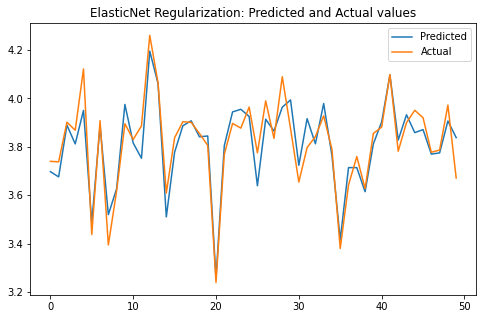

In [226]:
# plotting predicted and actual values
plt.figure(figsize=(8,5))
plt.plot(y_pred_elastic[:50])
plt.plot(np.array(y_test[:50]))
plt.legend(["Predicted","Actual"])
plt.title("ElasticNet Regularization: Predicted and Actual values")
plt.show()

In [227]:
# mean squared error of model on training dataset
# comparison between actual sales and predicted sales
ms_train_elastic = mean_squared_error(10**(y_train), 10**(y_train_pred_elastic))
# mean squared error of model on testing dataset
# comparison between actual sales and predicted sales
ms_test_elastic = mean_squared_error(10**(y_test), 10**(y_pred_elastic))

# root mean squared error of model on training dataset
rms_train_elastic = math.sqrt(ms_train_elastic)
# root mean squared error of model on testing dataset
rms_test_elastic = math.sqrt(ms_test_elastic)

# r2 score of model on training data
r2_score_train_elastic = r2_score(10**(y_train), 10**(y_train_pred_elastic))
# r2 score of model on testing data
r2_score_test_elastic = r2_score(10**(y_test), 10**(y_pred_elastic))

In [228]:
# adjusted r2 score of training data
adjusted_r2_train_elastic = 1 - ((1 - r2_score_train_elastic)*(N - 1))/(N - p - 1)
adjusted_r2_test_elastic = 1 - ((1 - r2_score_test_elastic)*(N - 1))/(N - p - 1)

In [229]:
print('Model Performance on Training Data')
print('Mean Squared Error:',ms_train_elastic)
print('Root Mean Squared Error:',rms_train_elastic)
print('R2 Score:', r2_score_train_elastic)
print('Adjusted R2 Score:', adjusted_r2_train_elastic)
print('\nModel Performance on Testing Data')
print('Mean Squared Error:',ms_test_elastic)
print('Root Mean Squared Error:',rms_test_elastic)
print('R2 Score:', r2_score_test_elastic)
print('Adjusted R2 Score:', adjusted_r2_test_elastic)

Model Performance on Training Data
Mean Squared Error: 1473533.0159568565
Root Mean Squared Error: 1213.8916821351304
R2 Score: 0.8473106657947979
Adjusted R2 Score: 0.8473079533301932

Model Performance on Testing Data
Mean Squared Error: 1470543.2474415535
Root Mean Squared Error: 1212.6595760730022
R2 Score: 0.8464749720357061
Adjusted R2 Score: 0.8464722447253379


## Decision Tree Regression

In [230]:
from sklearn.tree import DecisionTreeRegressor

In [231]:
# treeReg = DecisionTreeRegressor(min_samples_leaf=20)
# treeReg.fit(X_train,y_train)

In [232]:
# hyperparameter tuning
dtmodel =  DecisionTreeRegressor()
grid_parameters = {"min_samples_leaf": [10,20,30], "max_depth": [None, 3, 5], "splitter": ["best","random"]}
treeReg = GridSearchCV(dtmodel, param_grid = grid_parameters, scoring = 'neg_mean_squared_error', cv=3)

# fitting model
treeReg.fit(X_train,y_train)

GridSearchCV(cv=3, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [None, 3, 5],
                         'min_samples_leaf': [10, 20, 30],
                         'splitter': ['best', 'random']},
             scoring='neg_mean_squared_error')

In [233]:
#predictions
y_pred_treeReg = treeReg.predict(X_test)
y_train_pred_treeReg = treeReg.predict(X_train)

In [234]:
treeReg.best_params_

{'max_depth': None, 'min_samples_leaf': 10, 'splitter': 'best'}

In [235]:
print('Performance of Decision Tree model on testing data')
MSE_test_treeReg  = mean_squared_error(10**(y_test), 10**(y_pred_treeReg))
print("MSE_treereg :" , MSE_test_treeReg)

RMSE_test_treeReg = np.sqrt(MSE_test_treeReg)
print("RMSE_treereg :" ,RMSE_test_treeReg)

r2_test_treeReg = r2_score(10**(y_test), 10**(y_pred_treeReg))
print("R2_treereg :" ,r2_test_treeReg)

adjusted_r2_test_treeReg = 1 - ((1 - r2_test_treeReg)*(N - 1))/(N - p - 1)
print("Adjusted R2 scores :",adjusted_r2_test_treeReg)

Performance of Decision Tree model on testing data
MSE_treereg : 463905.727519874
RMSE_treereg : 681.1062527387882
R2_treereg : 0.9515681433278518
Adjusted R2 scores : 0.9515672829553992


In [236]:
print('Performance of Decision Tree model on training data')
MSE_train_treeReg  = mean_squared_error(10**(y_train), 10**(y_train_pred_treeReg))
print("MSE_treereg :" , MSE_train_treeReg)

RMSE_train_treeReg = np.sqrt(MSE_train_treeReg)
print("RMSE_treereg :" ,RMSE_train_treeReg)

r2_train_treeReg = r2_score(10**(y_train), 10**(y_train_pred_treeReg))
print("R2_treereg :" ,r2_train_treeReg)

adjusted_r2_train_treeReg = 1 - ((1 - r2_train_treeReg)*(N - 1))/(N - p - 1)
print("Adjusted R2 scores :",adjusted_r2_train_treeReg)

Performance of Decision Tree model on training data
MSE_treereg : 325437.9629612724
RMSE_treereg : 570.4717021564456
R2_treereg : 0.9662777112208873
Adjusted R2 scores : 0.9662771121579916


There is a slight boost in our overall scores for Decision Tree model as compared to all the other models we tried before

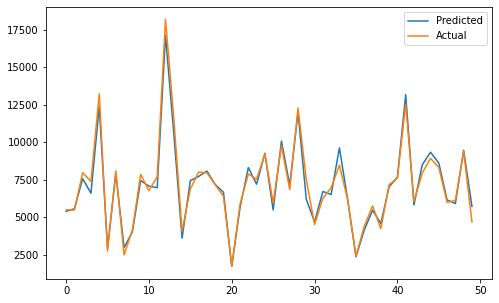

In [237]:
plt.figure(figsize=(8,5))
plt.plot((10**(y_pred_treeReg[:50])))
plt.plot(np.array((10**(y_test[:50]))))
plt.legend(["Predicted","Actual"])
plt.show()

In the plot above we can see that our prediction are matching the highs and lows of the sales figure quite accurately compared to the linear regression models.

### Random Forest Regression

In [238]:
from sklearn.ensemble import RandomForestRegressor

In [239]:
rdfreg = RandomForestRegressor(n_estimators=30, min_samples_leaf = 5)
rdfreg.fit(X_train,y_train)

RandomForestRegressor(min_samples_leaf=5, n_estimators=30)

In [240]:
# predictions
y_pred_rdfreg = rdfreg.predict(X_test)
y_train_pred_rdfreg = rdfreg.predict(X_train)

In [241]:
print("Performance of Random Forest Regression on testing data")
MSE_test_rdfreg  = mean_squared_error(10**(y_test), 10**(y_pred_rdfreg))
print("MSE_rdfreg :" , MSE_test_rdfreg)

RMSE_test_rdfreg = np.sqrt(MSE_test_rdfreg)
print("RMSE_rdfreg :" ,RMSE_test_rdfreg)

r2_test_rdfreg = r2_score(10**(y_test), 10**(y_pred_rdfreg))
print("R2_rdfreg :" ,r2_test_rdfreg)

adjusted_r2_test_rdfreg = 1 - ((1 - r2_test_rdfreg)*(N - 1))/(N - p - 1)
print("Adjusted R2 scores :",adjusted_r2_test_rdfreg)

Performance of Random Forest Regression on testing data
MSE_rdfreg : 359347.551537081
RMSE_rdfreg : 599.4560463762803
R2_rdfreg : 0.9624840391504205
Adjusted R2 scores : 0.9624833726944663


In [242]:
print("Performance of Random Forest Regression on training data")
MSE_train_rdfreg  = mean_squared_error(10**(y_train), 10**(y_train_pred_rdfreg))
print("MSE_rdfreg :" , MSE_train_rdfreg)

RMSE_train_rdfreg = np.sqrt(MSE_train_rdfreg)
print("RMSE_rdfreg :" ,RMSE_train_rdfreg)

r2_train_rdfreg = r2_score(10**(y_train), 10**(y_train_pred_rdfreg))
print("R2_rdfreg :" ,r2_train_rdfreg)

adjusted_r2_train_rdfreg = 1 - ((1 - r2_train_rdfreg)*(N - 1))/(N - p - 1)
print("Adjusted R2 scores :",adjusted_r2_train_rdfreg)

Performance of Random Forest Regression on training data
MSE_rdfreg : 225536.45067730395
RMSE_rdfreg : 474.9067810395046
R2_rdfreg : 0.976629630880337
Adjusted R2 scores : 0.9766292157151301


There is a slight boost in our overall scores for Random Forest model as compared to all the other models we tried before

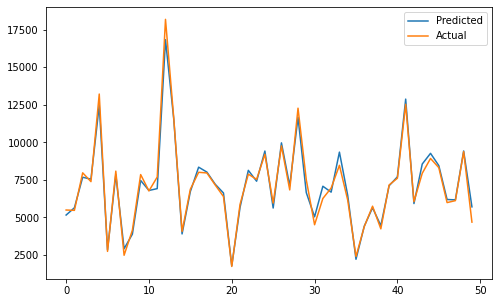

In [243]:
plt.figure(figsize=(8,5))
plt.plot((10**(y_pred_rdfreg[:50])))
plt.plot(np.array((10**(y_test[:50]))))
plt.legend(["Predicted","Actual"])
plt.show()

In the plot above we can see that our prediction are matching the highs and lows of the sales figure quite accurately

## Model Selection

Let's put the evaluation metrics together, and see which model performed better!

In [244]:
print("R2 scores of Models")
print('Linear Regression:', r2_score_test)
print('Lasso Regression:', r2_score_test_lasso)
print('Ridge Regression:', r2_score_test_ridge)
print('ElasticNet Regression:', r2_score_test_elastic)
print("Decision Tree Regression:" ,r2_test_treeReg)
print("Random Forest Regression:" ,r2_test_rdfreg)

R2 scores of Models
Linear Regression: 0.846474778432183
Lasso Regression: 0.8464749751158416
Ridge Regression: 0.8464750466738407
ElasticNet Regression: 0.8464749720357061
Decision Tree Regression: 0.9515681433278518
Random Forest Regression: 0.9624840391504205


In [245]:
print("Adjusted R2 scores of Models")
print('Linear Regression:', adjusted_r2_test)
print('Lasso Regression:', adjusted_r2_test_lasso)
print('Ridge Regression:', adjusted_r2_test_ridge)
print('ElasticNet Regression:', adjusted_r2_test_elastic)
print("Decision Tree Regression:" ,adjusted_r2_test_treeReg)
print("Random Forest Regression:" ,adjusted_r2_test_rdfreg)

Adjusted R2 scores of Models
Linear Regression: 0.8464720511183755
Lasso Regression: 0.8464722478055281
Ridge Regression: 0.8464723193647984
ElasticNet Regression: 0.8464722447253379
Decision Tree Regression: 0.9515672829553992
Random Forest Regression: 0.9624833726944663


Out of all the models, Random Forest Regression seems to be performing the best and Decision Tree Regressor has a very close R2 score as well. Linear regression model and the regularised linear regression models (Lasso, Ridge, ElasticNet) all have similar performance to each other. However, they perform worse compared to the decision tree and random forest models.

It is clear that random forest is our best performing model if we compares its R2 score against all the others.

### Feature Importance

Text(0.5, 0, 'Relative Importance')

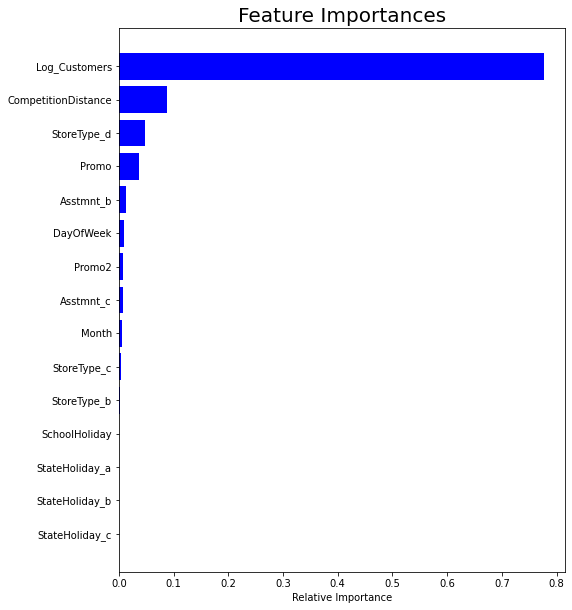

In [246]:
features_ = dataset[features].columns
importances = rdfreg.feature_importances_
indices = np.argsort(importances)
plt.figure(figsize=(8,10))
plt.title('Feature Importances', fontsize=20)
plt.barh(range(len(indices)), importances[indices], color='blue', align='center')
plt.yticks(range(len(indices)), features_[indices])
plt.xlabel('Relative Importance')

Customers and competition distance were found to be the most important features.

### Conclusion

So with this we are finally done with our project Retail Sales Prediction. At first we analysed carefully both the datasets that were provided to us, understanding each and every feature and what role it can play in affecting the sales price for the day, then we handled all the null values and performed some necessary transformations on few of the columns making sure that all the columns best correlate with the dependent variable.

Finally our dataset was ready for model implementation and evaluation. We, in total, fitted 6 models on our dataset of different levels of complexity. 

Out of all the models, Random Forest Regression seems to be performing the best followed by Decision Tree Regressor which has a very close score. Linear regression model and the regularised linear regression models (Lasso, Ridge, ElasticNet) all have similar performance to each other.